### ARTIFICIAL NEURAL NETWORKS

#### 
Case Study: SONAR — Detecting Mines vs. Rocks

1️.Business Objective

Goal:
To build an intelligent system that can automatically detect whether an underwater sonar signal is reflected from a metallic mine (potentially dangerous) or a harmless rock.

This is vital for:

1.Maritime safety: Prevent ships and submarines from colliding with mines.

2.Naval defense: Identify and safely remove underwater mines.

3.Resource exploration: Distinguish between useful metal structures and natural seabed objects.


### 
2️.Problem Statement

In underwater environments, sonar (sound navigation and ranging) is used to detect objects. However, raw sonar signals can be noisy and difficult for humans to interpret consistently.

This dataset:

•	Contains 208 sonar returns.
o	111 are from metal cylinders (mines).
o	97 are from rocks.
•	Each sonar return is represented by 60 numeric features, each measuring the energy of the signal in a frequency band.

The problem:

To train a Deep learning model that can learn the difference in signal patterns and classify new sonar signals as either Mine (M) or Rock (R) — accurately and reliably.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
import time
import warnings
warnings.filterwarnings('ignore')

#### Dataset: "sonardataset.csv"

Features (Inputs)
•	There are 60 numerical variables, each representing the energy in a specific frequency band of the sonar signal.
•	In the original dataset, they’re just unnamed columns V1, V2, ..., V60 — you can keep it clear and simple:

⃣2Target (Output)
•	The label is a single categorical variable indicating:
o	"M" for Mine
o	"R" for Rock


In [4]:
df = pd.read_csv('sonardataset.csv')
df.shape

(208, 61)

In [5]:
df.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_52,x_53,x_54,x_55,x_56,x_57,x_58,x_59,x_60,Y
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_1     208 non-null    float64
 1   x_2     208 non-null    float64
 2   x_3     208 non-null    float64
 3   x_4     208 non-null    float64
 4   x_5     208 non-null    float64
 5   x_6     208 non-null    float64
 6   x_7     208 non-null    float64
 7   x_8     208 non-null    float64
 8   x_9     208 non-null    float64
 9   x_10    208 non-null    float64
 10  x_11    208 non-null    float64
 11  x_12    208 non-null    float64
 12  x_13    208 non-null    float64
 13  x_14    208 non-null    float64
 14  x_15    208 non-null    float64
 15  x_16    208 non-null    float64
 16  x_17    208 non-null    float64
 17  x_18    208 non-null    float64
 18  x_19    208 non-null    float64
 19  x_20    208 non-null    float64
 20  x_21    208 non-null    float64
 21  x_22    208 non-null    float64
 22  x_

In [7]:
if df.shape[1] >= 2:
    labels = df.iloc[:, -1]
    print(labels.value_counts())

Y
M    111
R     97
Name: count, dtype: int64


In [8]:
numeric = df.select_dtypes(include=[np.number])
numeric.shape

(208, 60)

In [9]:
numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
x_1,208.0,0.029164,0.022991,0.0015,0.013350,0.02280,0.035550,0.1371
x_2,208.0,0.038437,0.032960,0.0006,0.016450,0.03080,0.047950,0.2339
x_3,208.0,0.043832,0.038428,0.0015,0.018950,0.03430,0.057950,0.3059
x_4,208.0,0.053892,0.046528,0.0058,0.024375,0.04405,0.064500,0.4264
x_5,208.0,0.075202,0.055552,0.0067,0.038050,0.06250,0.100275,0.4010
x_6,208.0,0.104570,0.059105,0.0102,0.067025,0.09215,0.134125,0.3823
x_7,208.0,0.121747,0.061788,0.0033,0.080900,0.10695,0.154000,0.3729
x_8,208.0,0.134799,0.085152,0.0055,0.080425,0.11210,0.169600,0.4590
x_9,208.0,0.178003,0.118387,0.0075,0.097025,0.15225,0.233425,0.6828
x_10,208.0,0.208259,0.134416,0.0113,0.111275,0.18240,0.268700,0.7106


In [10]:
 df.isnull().sum().sum()

np.int64(0)

In [11]:
X = df.iloc[:, :-1].values.astype(float)  
y_raw = df.iloc[:, -1].values

#### Tasks
1. Data Exploration and Preprocessing
   
●	Begin by loading and exploring the "Alphabets_data.csv" dataset. Summarize its key features such as the number of samples, features, and classes.
●	Execute necessary data preprocessing steps including data normalization, managing missing values.


In [12]:
le = LabelEncoder()
y = le.fit_transform(y_raw)

In [13]:
dict(zip(le.classes_, le.transform(le.classes_)))

{'M': np.int64(0), 'R': np.int64(1)}

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((166, 60), (42, 60), (166,), (42,))

#### 2. Model Implementation

●	Construct a basic ANN model using your chosen high-level neural network library. Ensure your model includes at least one hidden layer.
●	Divide the dataset into training and test sets.
●	Train your model on the training set and then use it to make predictions on the test set.


In [16]:
def build_model(input_dim, hidden_layers=(32,), activation='relu', dropout=0.0, lr=1e-3, optimizer_name='adam'):
    model = Sequential()
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation=activation))
    if dropout>0:
        model.add(Dropout(dropout))
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
        if dropout>0:
            model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    if optimizer_name == 'adam':
        opt = Adam(learning_rate=lr)
    else:
        opt = SGD(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
input_dim = X_train.shape[1]
base_params = dict(hidden_layers=(32,), activation='relu', dropout=0.0, lr=1e-3, optimizer_name='adam', epochs=50, batch_size=16)
print("Training baseline model:", base_params)
base_model = build_model(input_dim, hidden_layers=base_params['hidden_layers'],
                         activation=base_params['activation'], dropout=base_params['dropout'],
                         lr=base_params['lr'], optimizer_name=base_params['optimizer_name'])
hist_base = base_model.fit(X_train, y_train, validation_split=0.1, epochs=base_params['epochs'],
                           batch_size=base_params['batch_size'], verbose=1)
y_prob = base_model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

Training baseline model: {'hidden_layers': (32,), 'activation': 'relu', 'dropout': 0.0, 'lr': 0.001, 'optimizer_name': 'adam', 'epochs': 50, 'batch_size': 16}
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5034 - loss: 0.7300 - val_accuracy: 0.6471 - val_loss: 0.5926
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5772 - loss: 0.6283 - val_accuracy: 0.7059 - val_loss: 0.5254
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6779 - loss: 0.5585 - val_accuracy: 0.8235 - val_loss: 0.4772
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7651 - loss: 0.5088 - val_accuracy: 0.8824 - val_loss: 0.4414
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7785 - loss: 0.4685 - val_accuracy: 0.9412 - val_loss: 0.4149
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8121 - loss: 0.4357 - val_accuracy: 0.9412 - val_loss: 0.3927
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8255 - loss: 0

In [18]:
accuracy_score(y_test, y_pred)

0.8333333333333334

In [19]:
precision_score(y_test, y_pred)

0.8823529411764706

In [20]:
recall_score(y_test, y_pred)

0.75

In [21]:
f1_score(y_test, y_pred)

0.8108108108108109

In [22]:
classification_report(y_test, y_pred, target_names=le.classes_)

'              precision    recall  f1-score   support\n\n           M       0.80      0.91      0.85        22\n           R       0.88      0.75      0.81        20\n\n    accuracy                           0.83        42\n   macro avg       0.84      0.83      0.83        42\nweighted avg       0.84      0.83      0.83        42\n'

In [23]:
confusion_matrix(y_test, y_pred)

array([[20,  2],
       [ 5, 15]])

#### 3. Hyperparameter Tuning

●	Modify various hyperparameters, such as the number of hidden layers, neurons per hidden layer, activation functions, and learning rate, to observe their impact on model performance.
●	Adopt a structured approach like grid search or random search for hyperparameter tuning, documenting your methodology thoroughly.


In [26]:
param_grid = {
    'hidden_layers': [(16,), (32,), (64,), (32,32), (64,32)],
    'activation': ['relu','tanh'],
    'dropout': [0.0, 0.1, 0.2],
    'lr': [1e-2, 1e-3, 5e-4],
    'optimizer_name': ['adam','sgd'],
    'epochs': [50, 100],
    'batch_size': [8, 16]
}

In [27]:
from itertools import product
all_combinations = list(product(*(param_grid[k] for k in param_grid)))
len(all_combinations)

720

In [28]:
import random
n_iter = 12
random.seed(42)
sampled = random.sample(all_combinations, min(n_iter, len(all_combinations)))

In [29]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)


In [30]:
from tensorflow.keras.optimizers import Adam, SGD


In [31]:
start_all = time.time()
best_score = -1.0
best_res = None
results = []
for idx, combo in enumerate(sampled, 1):
    params = dict(zip(param_grid.keys(), combo))
    print(f"\n[{idx}/{len(sampled)}] Testing params: {params}")
    cv_scores = []
    # cross-validation loop
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model = build_model(input_dim, hidden_layers=params['hidden_layers'],
                            activation=params['activation'], dropout=params['dropout'],
                            lr=params['lr'], optimizer_name=params['optimizer_name'])
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
        yv = (model.predict(X_val).ravel() >= 0.5).astype(int)
        cv_scores.append(f1_score(y_val, yv, zero_division=0))
    mean_cv = np.mean(cv_scores)
    results.append((params, mean_cv))
    print(" -> mean CV F1:", mean_cv)
    if mean_cv > best_score:
        best_score = mean_cv
        best_res = (params, mean_cv)
end_all = time.time()
print(f"\nRandom search done in {(end_all - start_all)/60:.2f} minutes.")
print("Best CV F1:", best_score)
print("Best params:", best_res[0])


[1/12] Testing params: {'hidden_layers': (64, 32), 'activation': 'tanh', 'dropout': 0.0, 'lr': 0.01, 'optimizer_name': 'sgd', 'epochs': 100, 'batch_size': 8}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
 -> mean CV F1: 0.8371406371406371

[2/12] Testing params: {'hidden_layers': (16,), 'activation': 'tanh', 'dropout': 0.1, 'lr': 0.0005, 'optimizer_name': 'adam', 'epochs': 100, 'batch_size': 8}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
 -> mean CV F1: 0.7677314945116802

[3/12] Testing params: {'hidden_layers': (16,), 'activation': 'relu', 'dropout': 0.1, 'lr': 0.01, 'optimizer_name': 'adam', 'epochs': 50, 'batch_size': 16}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

### 4. Evaluation
●	Employ suitable metrics such as accuracy, precision, recall, and F1-score to evaluate your model's performance.
●	Discuss the performance differences between the model with default hyperparameters and the tuned model, emphasizing the effects of hyperparameter tuning.

Evaluation Criteria

●	Accuracy and completeness of the implementation.
●	Proficiency in data preprocessing and model development.
●	Systematic approach and thoroughness in hyperparameter tuning.
●	Depth of evaluation and discussion.
●	Overall quality of the report.

Additional Resources

●	TensorFlow Documentation
●	Keras Documentation
We wish you the best of luck with this assignment. Enjoy exploring the fascinating world of neural networks and the power of hyperparameter tuning!


In [32]:
best_params = best_res[0]
final_model = build_model(input_dim, hidden_layers=best_params['hidden_layers'],
                          activation=best_params['activation'], dropout=best_params['dropout'],
                          lr=best_params['lr'], optimizer_name=best_params['optimizer_name'])

In [33]:
best_params

{'hidden_layers': (64, 32),
 'activation': 'tanh',
 'dropout': 0.0,
 'lr': 0.01,
 'optimizer_name': 'sgd',
 'epochs': 100,
 'batch_size': 8}

In [34]:
hist_final = final_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1, validation_split=0.1)
y_prob_final = final_model.predict(X_test).ravel()
y_pred_final = (y_prob_final >= 0.5).astype(int)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5302 - loss: 0.6931 - val_accuracy: 0.6471 - val_loss: 0.5971
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7114 - loss: 0.5880 - val_accuracy: 0.6471 - val_loss: 0.5405
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7584 - loss: 0.5320 - val_accuracy: 0.7647 - val_loss: 0.5070
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7785 - loss: 0.4973 - val_accuracy: 0.7059 - val_loss: 0.4826
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7852 - loss: 0.4724 - val_accuracy: 0.7059 - val_loss: 0.4663
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7919 - loss: 0.4532 - val_accuracy: 0.7059 - val_loss: 0.4529
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8054 - loss: 0.4361 - val_accuracy: 0.7059 - val_loss: 0.4400
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8054 - loss: 0.4216 - val_accuracy: 0.7059 - 

In [35]:
accuracy_score(y_test, y_pred_final)

0.8095238095238095

In [36]:
precision_score(y_test, y_pred_final, zero_division=0)

0.9285714285714286

In [37]:
recall_score(y_test, y_pred_final, zero_division=0)

0.65

In [38]:
f1_score(y_test, y_pred_final, zero_division=0)

0.7647058823529411

In [39]:
classification_report(y_test, y_pred_final, target_names=le.classes_)

'              precision    recall  f1-score   support\n\n           M       0.75      0.95      0.84        22\n           R       0.93      0.65      0.76        20\n\n    accuracy                           0.81        42\n   macro avg       0.84      0.80      0.80        42\nweighted avg       0.84      0.81      0.80        42\n'

In [40]:
confusion_matrix(y_test, y_pred_final)

array([[21,  1],
       [ 7, 13]])

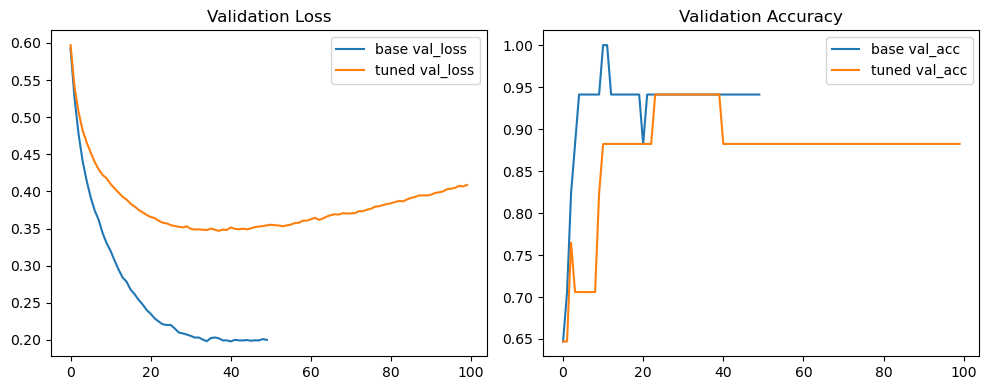

In [42]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist_base.history['val_loss'], label='base val_loss')
plt.plot(hist_final.history['val_loss'], label='tuned val_loss')
plt.title("Validation Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_base.history['val_accuracy'], label='base val_acc')
plt.plot(hist_final.history['val_accuracy'], label='tuned val_acc')
plt.title("Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
summary = {
    'baseline': {
        'params': base_model ,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
    },
    'best': {
        'params': base_model ,
        'cv_f1': best_score,
        'test_accuracy': accuracy_score(y_test, y_pred_final),
        'test_precision': precision_score(y_test, y_pred_final, zero_division=0),
        'test_recall': recall_score(y_test, y_pred_final, zero_division=0),
        'test_f1': f1_score(y_test, y_pred_final, zero_division=0)
    }
}

In [44]:
summary

{'baseline': {'params': <Sequential name=sequential, built=True>,
  'accuracy': 0.8333333333333334,
  'precision': 0.8823529411764706,
  'recall': 0.75,
  'f1': 0.8108108108108109},
 'best': {'params': <Sequential name=sequential, built=True>,
  'cv_f1': np.float64(0.8371406371406371),
  'test_accuracy': 0.8095238095238095,
  'test_precision': 0.9285714285714286,
  'test_recall': 0.65,
  'test_f1': 0.7647058823529411}}